# Анализ факторов, влияющих на продажи 

**Заказчик**: Golden Light VIP Elite 

За предыдущий период отдел потратил достаточно много денег на рекламу в различных источниках, организацию распродаж, а также периодически проводил исследования предпочтений рынка. И хочется узнать, что из этого принесло реальную пользу продажам, а на что деньги потратились просто так. Нам также хочется понимать, сколько мы можем зарабатывать, если не будем тратить ресурсы на неэффективные действия.
    
**Задачи исследования**: 
    
1. Какие действия отдела продаж оказывают позитивное влияние на показатели продаж?
2. Какие действия не приносят видимого эффекта?
3. Какая линейная модель позволит спрогнозировать продажи в каком-либо месяце?

## Cбор и обработка данных 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
mark_data = pd.read_csv('lights_sales_data.csv')
mark_data.head()

,month_number,TV,Radio,Newspapers,Surveys,total_marketing_spendings,"total_marketing_spendings, $",days_in_month,days_of_sales,sales
0,1,230.1,37.8,69.2,9.2,337.1,5.170245,29,12,45.2
1,2,44.5,39.3,45.1,24.9,128.9,1.976994,30,17,38.1
2,3,17.2,45.9,69.3,10.6,132.4,2.030675,31,9,36.7
3,4,151.5,41.3,58.5,30.0,251.3,3.854294,30,17,41.0
4,5,180.8,10.8,58.4,13.2,250.0,3.834356,31,2,37.6


При прогнозировании данных нужно проверить параметры модели на **мультиколлинеарность** с помощью **матрицы корреляций**.

In [3]:
# При построении матрицы убираем столбцы 'month_number', 'sales' 

сorrelation_map = mark_data.loc[:, [x for x in mark_data.columns if x != 'month_number' and x != 'sales' ]].corr()
сorrelation_map

,TV,Radio,Newspapers,Surveys,total_marketing_spendings,"total_marketing_spendings, $",days_in_month,days_of_sales
TV,1.000000,0.054809,0.056648,0.007348,0.945330,0.945330,0.012663,0.171939
Radio,0.054809,1.000000,0.354104,0.061084,0.293211,0.293211,0.111377,0.048575
Newspapers,0.056648,0.354104,1.000000,-0.043030,0.343059,0.343059,0.060290,-0.033053
Surveys,0.007348,0.061084,-0.043030,1.000000,0.006459,0.006459,0.109435,0.068414
total_marketing_spendings,0.945330,0.293211,0.343059,0.006459,1.000000,1.000000,0.043596,0.158768
"total_marketing_spendings, $",0.945330,0.293211,0.343059,0.006459,1.000000,1.000000,0.043596,0.158768
days_in_month,0.012663,0.111377,0.060290,0.109435,0.043596,0.043596,1.000000,0.233911
days_of_sales,0.171939,0.048575,-0.033053,0.068414,0.158768,0.158768,0.233911,1.000000


# Cтроим тепловую карту корреляций 

<AxesSubplot:title={'center':'Мартица корреляций'}>

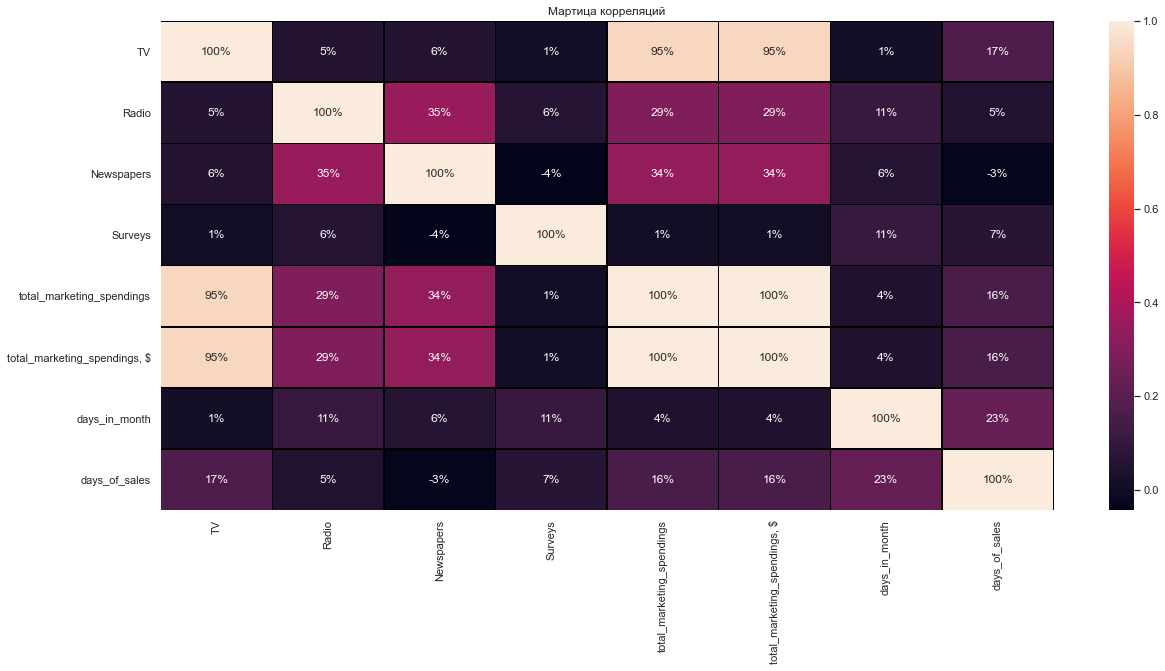

In [4]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Мартица корреляций')
sns.heatmap(сorrelation_map, mask=сorrelation_map.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black')

На тепловой карте корреляций уже лучше видно, что есть переменные, сильно коррелирующие друг с другом.  Total_marketing_spendings сильно коррелирует с TV. Также заметна корреляция total_marketing_spendings с Radio, Newspapers. Из этого можно предположить, что затраты на TV, Radio, Newspapers входят в total_marketing_spendings. Необходимо дополнительно проверить их корреляцию. 


Переменные total_marketing_spendings и total_marketing_spendings,$, имеют корреляцию 1, то есть они полностью линейно зависимы. 
При наличии таких переменных нужно оставить лишь одну для модели, оставим те затраты, что в рублях (т.е. приведем данные к единой валюте для удобства дальнейших расчетов):

In [5]:
mark_data = mark_data.loc[:, [x for x in mark_data.columns if x != 'total_marketing_spendings, $']]

Также мы видим, что переменная total_marketing_spendings скоррелирована с переменными TV, Newspapers, Radio.
Возможно, total_marketing_spendings — просто сумма этих трёх параметров (о чем нам и говорит название).
Давайте проверим их корреляцию:

In [6]:
pd.DataFrame([mark_data.loc[:, ['TV', 'Radio', 'Newspapers']].sum(axis = 1), mark_data.total_marketing_spendings]).T.corr()

,Unnamed 0,total_marketing_spendings
Unnamed 0,1.0,1.0
total_marketing_spendings,1.0,1.0


Переменные TV, Newspapers, Radio в сумме дают столбец total_marketing_spendings. 
В таком случае лучше оставить более низкоуровневые параметры, чтобы отслеживать их влияние на результат. 
Поэтому исключим столбец total_marketing_spendings:

In [7]:
mark_data = mark_data.loc[:, [x for x in mark_data.columns if x != 'total_marketing_spendings']]
mark_data.head()

,month_number,TV,Radio,Newspapers,Surveys,days_in_month,days_of_sales,sales
0,1,230.1,37.8,69.2,9.2,29,12,45.2
1,2,44.5,39.3,45.1,24.9,30,17,38.1
2,3,17.2,45.9,69.3,10.6,31,9,36.7
3,4,151.5,41.3,58.5,30.0,30,17,41.0
4,5,180.8,10.8,58.4,13.2,31,2,37.6


Теперь можно визуально посмотреть, какие параметры коррелируют с продажами, построим графики для всех переменных с подсчетом коэффициента детерминации

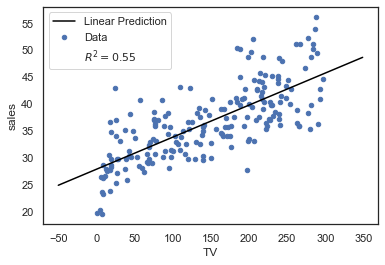

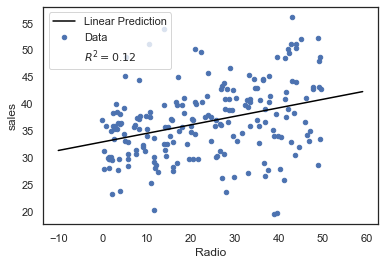

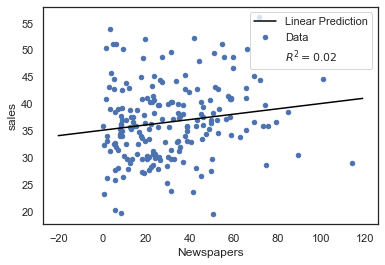

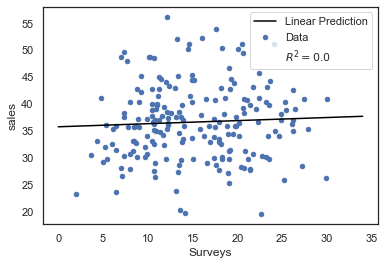

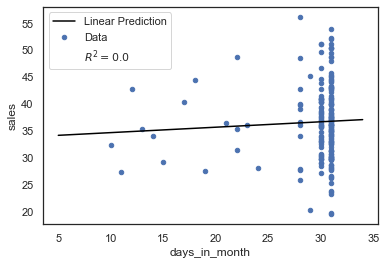

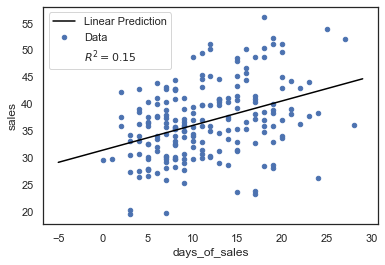

In [8]:
for col in mark_data.iloc[:, 1:-1].columns:
    ax = plt.subplot()
    mark_data.plot(x = col, y = 'sales', kind = 'scatter', ax = ax, label = 'Data')
    model = LinearRegression()
    model.fit(mark_data.loc[:, [col]] #используем такой синтаксис, так как на вход должна опдаваться линейная модель
              , mark_data.sales)
    r_sq = model.score(mark_data.loc[:, [col]], mark_data.sales)
    ax.plot(list(range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1]))),
            [model.intercept_ + model.coef_*x for x in list(range(int(ax.get_xticks()[0]), int(ax.get_xticks()[-1])))]
            , label = 'Linear Prediction', color = 'black')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label='$R^2 = ' + str(round(r_sq, 2)) + '$'))
    ax.legend(handles = handles)
    plt.show()

Есть несколько параметров, относительно которых линейная модель как-то коррелирует с продажами: 

- TV
- Radio
- Newspapers
- Days of sales

Остальные параметры нужно убрать из датасета, т.к.  они не объясняют дисперсию в данных (days_in_month и Surveys не стоит использовать для построения модели).

In [9]:
mark_data = mark_data.loc[:, [x for x in mark_data.columns if x != 'days_in_month' and x != 'Surveys']]

Получим параметры линейной регрессии:

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     113.6
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           8.14e-50
Time:                        10:57:49   Log-Likelihood:                -549.52
No. Observations:                 200   AIC:                             1109.
Df Residuals:                     195   BIC:                             1126.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.8616      0.843     25.921

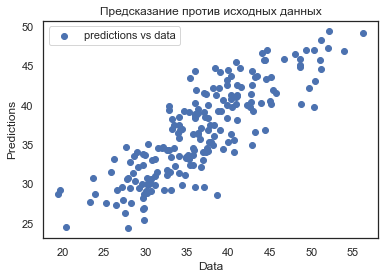

In [10]:

X = sm.add_constant(mark_data.iloc[:, 1:-1])
 
model = sm.OLS(mark_data.sales, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)
plt.scatter(mark_data.sales, predictions, label = 'predictions vs data')
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.title('Предсказание против исходных данных')
plt.legend()
plt.show()

R-squared, коэффициент детерминации, который показывает, какую долю дисперсии мы можем объяснить нашей моделью. В нашем случае итоговая модель обьясняет дисперсию на 70 %. Это говорит о том, что переменных достаточно для получения всех закономерностей в данных с помощью линейной модели. Prob (F-statistic): 113.6. Полученное значение говорит нам о вероятности того, что модель описывает данные статистически значимо. Статистика Дурбина-Ватсона показывает, что автокорреляции нет (т. к. статистика близка к 2).

## Проверка ошибок

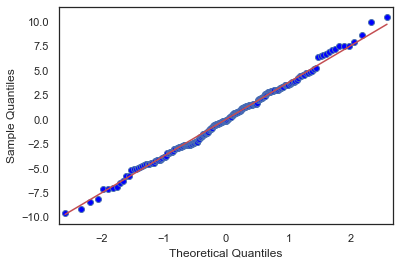

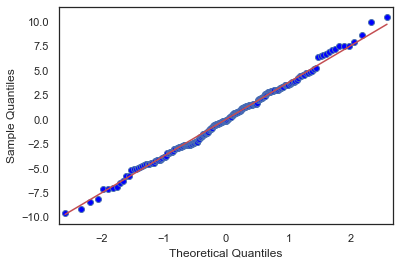

In [11]:
#Проверим, что ошибка измерения случайна и имеет постоянный разброс, с помощью QQ-plot:

qqplot(model.resid   # Ошибки модели
       , line = 's')

Как мы видим из QQ-plot, распределение ошибок нормальное, то есть имеет постоянный разброс и является случайной величиной, распределённой нормально.

Oшибки не коррелируют с параметрами модели, а значит, применение линейной модели легально.

In [12]:
#Проверим, что ошибки измерений не зависят сами от себя (отсутствие самокорреляции):

durbin_watson(model.resid)

2.2869127436631884

Дополнительный расчет статистики Дурбина-Ватсона подтверждает, что автокорреляции нет (т. к. статистика близка к 2).

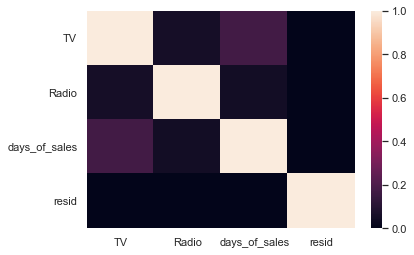

In [13]:
#Проверим также ошибки на корреляцию со значимыми параметрами модели:

mark_data['resid'] = model.resid
sns.heatmap(mark_data.loc[:, ['TV', 'Radio', 'days_of_sales', 'resid']].corr());

Ошибки не коррелируют с параметрами модели, а значит, применение линейной модели легально.

## Коэффициенты линейной регрессии и их значимость.

По информации из отчета для параметра Newspapers не выявлено значимое влияние на продажи (p-value >= 0.05), поэтому его придётся исключить из финальной модели. 

**Итоговая линейная модель** предсказания продаж будет выглядеть следующим образом:

Sales = 0.055∗TV + 0.131∗Radio + 0.302∗days_of_sales + 21.862

## Выводы:

- Без дополнительных усилий (без рекламы, акций и продаж на выставках) компания достаточно стабильно продаёт на 21.862. Причём интервал продаж небольшой (от 20.198 до 23.525).
- Значимый вклад в продажи вносят релама на телевидении(TV), радио(Radio) и распродажи(days_of_sales). Реклама на радио окупается лучше, чем реклама на ТВ. В них стоит вкладываться, если реклама на телевидении стоит меньше, чем 0.055; реклама на радио дешевле, чем 0.131; проведение распродажи дешевле, чем 0.302. 
- Не стоит вкладываться в рекламу в газетах (Newspapers), они не приносят значимого улучшения продаж.
- Также не стоит тратить средства на исследования предпочтений рынка (Surveys) - они не влияют на продажи. 
- Линейная модель для расчёта продаж в каком-либо месяце: Sales=0.055∗TV+0.131∗Radio+0.302∗days_of_sales+21.862

## Рекомендации:
- Самое сильное влияние на продажи оказывает реклама на TV - можно попробовать увеличить ее бюджет для привлечения еще большего кол-ва покупателей. 
- В качестве нового источника привлечения покупателей стоит протестировать интернет-рекламу. 
- Пересмотреть условия и количество распродаж, акций для клиентов.